In [2]:
from __future__ import print_function, division
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time
import os
import copy
import sys

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import urllib.request as urllib2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATASET_PATH = './Dataset/'

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [4]:
class_name = ["aeroplane",
              "bicycle",
              "bird",
              "boat",
              "bottle",
              "bus",
              "car",
              "cat",
              "chair",
              "cow",
              "diningtable",
              "dog",
              "horse",
              "motorbike",
              "person",
              "pottedplant",
              "sheep",
              "sofa",
              "train",
              "tvmonitor"
             ]

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = models.vgg16(pretrained=False)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=len(class_names))
model = model.to(device)

In [8]:
model.load_state_dict(torch.load('./TrainedModel/PretrainedTrue'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            for i in outputs:
                print(i)
            _, preds = torch.max(outputs, 1)
            
            print(preds.size)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            
        model.train(mode=was_training)

tensor([-2.5719, -5.4555, -2.8456,  7.8487, -3.3286, -5.9267, -0.8443,  1.1678,
         9.1875, -2.2243, -6.3446,  0.2621, 15.6491, -3.7164,  0.7706, -7.4810,
        -5.5459, 15.4968, -1.1700, -1.4107], device='cuda:0')
tensor([-2.8137, -3.7202, 10.6804, -0.8095, -3.5660, -3.2358,  1.8652, -1.8459,
         1.3009,  1.3886, -2.6781,  1.9972, -0.6748, -0.3756,  7.5596, -5.2583,
        -3.9965,  0.2032,  5.7533, -1.2142], device='cuda:0')
tensor([ -5.5541, -11.8017,   6.7828,  -6.9101,  -7.6145,  -7.6867,   7.6737,
         -4.4870,  -9.9422,  52.6069,  -4.8198,   1.8470, -15.7778,  -4.0116,
         -2.5084,  -4.7947,   1.1640,  -4.9387,  29.0332,  -6.8037],
       device='cuda:0')
tensor([-5.3110, -5.2714,  2.7548, -0.7681, -4.1378, -5.1739,  1.2427, -1.0687,
        -1.9354, 10.5733, -5.6513,  3.9627, -1.7770, -1.9915, -3.5891, -5.5061,
        -3.5815, 18.9975, 12.9979, -3.8051], device='cuda:0')
<built-in method size of Tensor object at 0x7f530b583fc0>


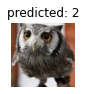

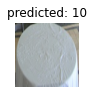

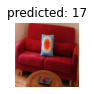

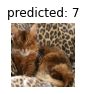

tensor([-1.9809, 25.5326, -0.8296, -0.7399, -3.0302, 15.6274,  2.0320, -2.6252,
        -4.5269, -4.9505, -2.6762, -5.8278, -4.3272, -2.9430, -0.0548, -3.0440,
         4.7648, -3.9116,  0.5670, -5.5418], device='cuda:0')
tensor([ -5.4055, -12.8585,   5.3640, -14.3364, -17.8969, -17.4286,  -0.0688,
          1.2668,  -9.7488,  -4.7243,   3.7064,  63.7017, -12.7308,   0.2493,
          6.5823,  15.2687,   3.6730,  -1.4582,  12.2285, -14.1366],
       device='cuda:0')
tensor([ -0.7311,  -2.2637,  -9.7819,   8.6526,   0.5119,  -1.5543,   8.9645,
         -1.0150,   9.6184,  -4.1433,  -6.2532,  -8.9137,  22.5316,   0.5150,
         -0.4801, -10.5703,  -6.9631,  -0.1694,  -1.9229,   6.3041],
       device='cuda:0')
tensor([ 2.1440e+00,  1.3040e+00,  1.3032e+01, -4.4664e+00, -6.6402e+00,
         4.8801e-01, -1.0051e+00,  8.6308e-05, -4.3723e+00,  6.8616e-01,
        -1.1855e+00, -7.2880e-01, -2.0983e+00,  6.5691e+00,  1.4928e-01,
        -4.6984e+00, -6.2524e-01, -6.2376e+00,  1.3472e+01, -

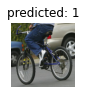

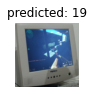

In [11]:
visualize_model(model)

In [41]:
def cv2_selective_search(img, searchMethod='f'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    
    if searchMethod == 'f':
        ss.switchToSelectiveSearchFast()
    elif searchMethod == 'q':
        ss.switchToSelectiveSearchQuality()
        
    regions = ss.process()
    
    return regions

In [13]:
def draw_bounding_box(bounding_box, img):
    tmp_img = img.copy()

    dim = np.array(bounding_box).ndim
    
    if dim == 2:
        for x, y, w, h in bounding_box:
            cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    elif dim == 3:
        for bb in bounding_box:
            for x, y, w, h in bb:
                cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    return cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

In [35]:
IMG_URL = "https://www.telegraph.co.uk/content/dam/Travel/2018/January/white-plane-sky.jpg?imwidth=450"

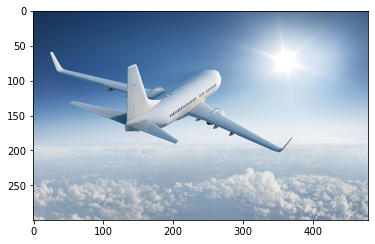

In [36]:

img = Image.open(urllib2.urlopen(IMG_URL))

opencvImg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(opencvImg, cv2.COLOR_BGR2RGB))

In [13]:
def get_predict(model, img):
    model.eval()
    
    with torch.no_grad():
        inputs = img.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs, 1)
        print(_)
        print(preds)
        return(_,class_name[preds])

In [37]:
_img = img
_img = data_transforms['test'](transforms.ToPILImage()(np.asarray(_img)))
get_predict(model, _img)

tensor([29.1895], device='cuda:0')
tensor([0], device='cuda:0')


(tensor([29.1895], device='cuda:0'), 'aeroplane')

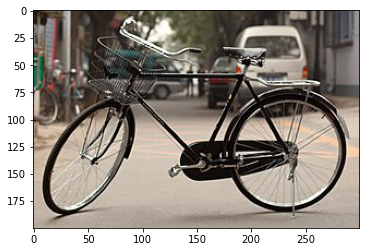

In [84]:
img = Image.open(DATASET_PATH+'sample/bicycle_2.jpg')

opencvImg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(opencvImg, cv2.COLOR_BGR2RGB))

In [99]:
_img = img
_img = data_transforms['test'](transforms.ToPILImage()(np.asarray(_img)))
get_predict(model, _img)

tensor([13.9307], device='cuda:0')
tensor([4], device='cuda:0')


(tensor([13.9307], device='cuda:0'), 'bottle')

num of all regions by ss: 1836


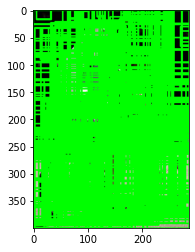

In [72]:
SS_BB = cv2_selective_search(opencvImg)

print(f'num of all regions by ss: {len(SS_BB)}')
plt.imshow(draw_bounding_box(SS_BB, opencvImg))

In [76]:
def get_candidate_bounding_box(SS_BB):
    bounding_box = []
    
    for index, ss_bb in enumerate(SS_BB):
        if index < 100:
            bounding_box.append(ss_bb)
    return bounding_box

In [78]:
bounding_box = get_candidate_bounding_box(SS_BB)

In [79]:
scores = []
labels = []

for index, (x, y, w, h) in enumerate(bounding_box):
    area = (x,y,x+w,y+h)
    timage = img.crop(area)
    timage = data_transforms['test'](transforms.ToPILImage()(np.asarray(timage)))
    (score, label) = get_predict(model, timage)
    
    scores.append(score)
    labels.append(label)
    
keep = torchvision.ops.nms(torch.tensor(bounding_box).float(), torch.tensor(scores).float(), 0.5)

for index, (result, bbox, label) in enumerate(zip(keep, bounding_box, labels)):
    if result == True:
        x,y,w,h, = bbox
        opencvImg = cv2.rectangle(opencvImg, (x, y,), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(opencvImg, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    
#cv2.imsave(opencvImg)
plt.imsave("result.jpg",cv2.cvtColor(opencvImg, cv2.COLOR_BGR2RGB))

tensor([5.9524], device='cuda:0')
tensor([7], device='cuda:0')
tensor([3.5473], device='cuda:0')
tensor([18], device='cuda:0')
tensor([5.4190], device='cuda:0')
tensor([16], device='cuda:0')
tensor([3.3800], device='cuda:0')
tensor([18], device='cuda:0')
tensor([4.1856], device='cuda:0')
tensor([0], device='cuda:0')
tensor([2.5060], device='cuda:0')
tensor([8], device='cuda:0')
tensor([4.7427], device='cuda:0')
tensor([13], device='cuda:0')
tensor([3.0460], device='cuda:0')
tensor([12], device='cuda:0')
tensor([3.7867], device='cuda:0')
tensor([9], device='cuda:0')
tensor([6.9722], device='cuda:0')
tensor([14], device='cuda:0')
tensor([4.5438], device='cuda:0')
tensor([14], device='cuda:0')
tensor([3.5814], device='cuda:0')
tensor([19], device='cuda:0')
tensor([5.2000], device='cuda:0')
tensor([14], device='cuda:0')
tensor([3.5880], device='cuda:0')
tensor([18], device='cuda:0')
tensor([6.5824], device='cuda:0')
tensor([12], device='cuda:0')
tensor([4.9250], device='cuda:0')
tensor([11